# Data Analysis:
### Table 1: Measured vs. Computed
### Figure 2: ODP-RSP-Ionicity correlation
### Figure 3: ODP-RSP according to materials groups
### Figure 5: Hardness-RSP
### SI Figures: RSP measured vs. computed

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
####################################
from pymatgen.core import Composition
####################################
from matplotlib import pyplot as plt
from matplotlib import patches, cm, colors
from matplotlib import patheffects as pe
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation
from matplotlib.markers import MarkerStyle
####################################
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
plt.rcParams.update({"figure.facecolor":(1.0, 1.0, 1.0, 0.0),
                     "axes.facecolor":(1.0, 1.0, 1.0, 0.0)})
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams["font.size"] = 30
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.it'] = 'Helvetica'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['figure.figsize'] = (10,8)

In [3]:
adf = pd.read_excel('C:/Users/mualemy5/Desktop/Self-healing/Supporting_Tables.xlsx', sheet_name='S1 - Full Dataset')

In [4]:
adf = adf.loc[[i for i, r in adf.iterrows() if r.ionicity!=r.ionicity or (r.ionicity>=0) or
               any(a in r.chemical_formula for a in ['YSZ', 'La1.'])]] #no negative ionicity

In [5]:
df = adf.groupby(['chemical_formula', 'space_group', 'cation_coordination']).mean(numeric_only=True).reset_index()

# Table 1: Measured vs. Computed analysis

In [6]:
ODPt1_adf = adf.dropna(subset='ODP_ref')
RSPt1_adf = adf.dropna(subset='RSP_ref')

ODPt1_adf['ODPt'] = [int('00811-w' in r.ODP_ref or '01153-x' in r.ODP_ref) for i, r in ODPt1_adf.iterrows()]
RSPt1_adf['RSPt'] = [int('Materials Project' in r.RSP_ref) for i, r in RSPt1_adf.iterrows()]

table1_prec = pd.DataFrame(columns=['materials with property', 'materials without property',
                                    'experimental data points', 'computed data points'],
                           index=['RSP', 'ODP', 'Hardness', 'Ionicity'])

table1_num = pd.DataFrame(columns=['materials with property', 'materials without property',
                                   'experimental data points', 'computed data points'],
                          index=['RSP', 'ODP', 'Hardness', 'Ionicity'])

ladf = len(adf)
table1_prec.loc['RSP'] = [len(adf.dropna(subset=['e_ionic']))/ladf*100, 100-len(adf.dropna(subset=['e_ionic']))/ladf*100,
                          100-RSPt1_adf.RSPt.sum()/len(RSPt1_adf)*100, RSPt1_adf.RSPt.sum()/len(RSPt1_adf)*100]
table1_prec.loc['ODP'] = [len(adf.dropna(subset=['ODP']))/ladf*100, 100-len(adf.dropna(subset=['ODP']))/ladf*100,
                          100-ODPt1_adf.ODPt.sum()/len(ODPt1_adf)*100, ODPt1_adf.ODPt.sum()/len(ODPt1_adf)*100]
table1_prec.loc['Hardness'] = [len(adf.dropna(subset='hardness'))/ladf*100, 100-len(adf.dropna(subset='hardness'))/ladf*100,
                               100, 0]
table1_prec.loc['Ionicity'] = [(len(adf.dropna(subset='ionicity'))-len(adf.loc[adf.ionicity==np.inf]))/ladf*100, 100-(len(adf.dropna(subset='ionicity'))-len(adf.loc[adf.ionicity==np.inf]))/ladf*100,
                               0, 100]

table1_num.loc['RSP'] = [len(adf.dropna(subset=['e_ionic'])), ladf-len(adf.dropna(subset=['e_ionic'])),
                         len(RSPt1_adf)-RSPt1_adf.RSPt.sum(), RSPt1_adf.RSPt.sum()]
table1_num.loc['ODP'] = [len(adf.dropna(subset=['ODP'])), ladf-len(adf.dropna(subset=['ODP'])),
                         len(ODPt1_adf)-ODPt1_adf.ODPt.sum(), ODPt1_adf.ODPt.sum()]
table1_num.loc['Hardness'] = [len(adf.dropna(subset='hardness')), ladf-len(adf.dropna(subset='hardness')),
                               len(adf.dropna(subset='hardness')), 0]
table1_num.loc['Ionicity'] = [len(adf.dropna(subset='ionicity'))-len(adf.loc[adf.ionicity==np.inf]), ladf-(len(adf.dropna(subset='ionicity'))-len(adf.loc[adf.ionicity==np.inf])),
                               0, len(adf.dropna(subset='ionicity'))-len(adf.loc[adf.ionicity==np.inf])]

In [7]:
table1_num

,materials with property,materials without property,experimental data points,computed data points
RSP,3761,6725,285,3476
ODP,9756,730,8,9748
Hardness,808,9678,808,0
Ionicity,8576,1910,0,8576


In [8]:
table1_prec

,materials with property,materials without property,experimental data points,computed data points
RSP,35.86687,64.13313,7.577772,92.422228
ODP,93.038337,6.961663,0.082001,99.917999
Hardness,7.705512,92.294488,100,0
Ionicity,81.785237,18.214763,0,100


# Figure 2: ODP-RSP-Ionicity correlation

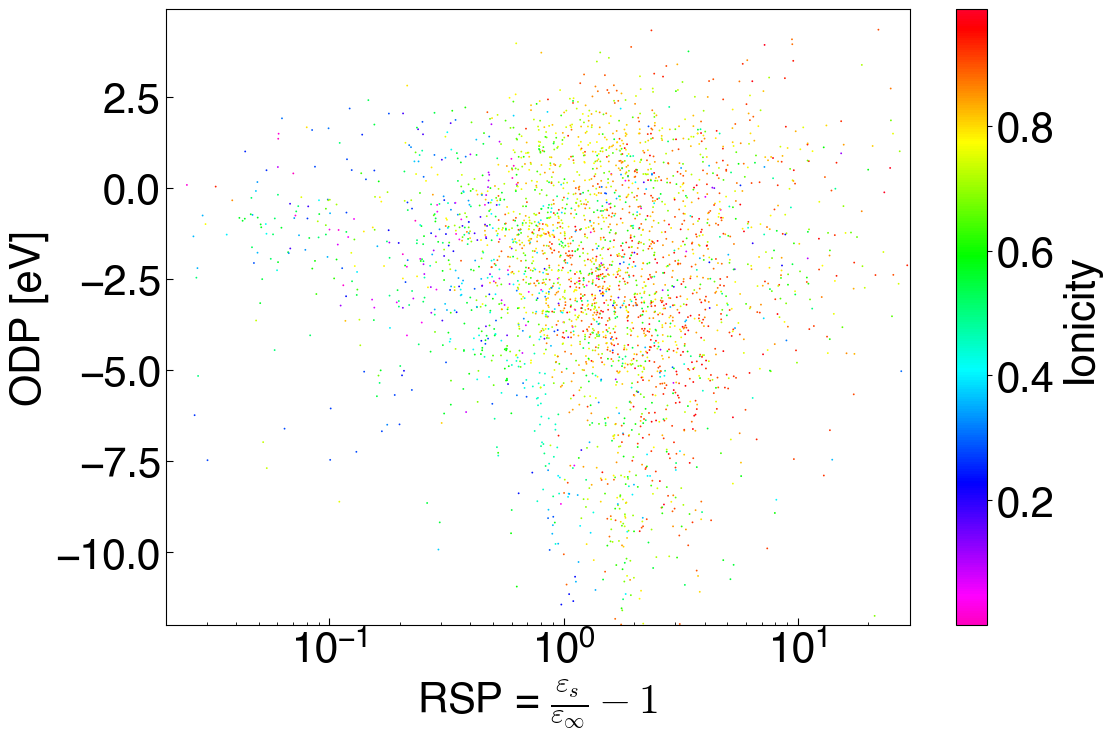

In [9]:
plt.figure(figsize=(12,8))
cmap = 'gist_rainbow_r'

plt.scatter(df.e_ionic/df.e_electronic, df.ODP, c=df.ionicity, cmap=cmap,s=7, marker='.',
            alpha=1, edgecolor='none')

cb = plt.colorbar(label='Ionicity')
plt.xscale('log')
plt.tick_params(direction='in', length=5, which='both')
plt.gca().xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
plt.tick_params(axis='x', which='minor', length=2.5)
plt.xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\\infty}}-1$')
plt.ylabel('ODP [eV]')

plt.xlim([2e-2, 3e1])
plt.ylim([-12, 4.9])

plt.yticks([2.5, 0, -2.5, -5, -7.5, -10])
plt.show()

# Figure 3: ODP-RSP according to materials groups

In [10]:
evac = pd.read_csv('C:/Users/mualemy5/SH_bond_properties/oxygen_vacancies_enthalpies.csv') #for the CSOFCs

In [11]:
haps = [] #Halide Perovskites (green)
alkali_halides = [] #Alkali Halides (yellow)
coinage_halides = [] #Coinage Halides (orange)
chalcohalides = [] #Chalcohalides (purple)
chalcopyrites = [] #Chalcopyrites (red)
CSOFCs = [] #Ceramics for solid oxide fuel cells (blue)

for index, row in df.iterrows():
    if 'YSZ' in row.chemical_formula or 'La1.' in row.chemical_formula:
        CSOFCs.append(index)
        continue
        
    comp = Composition(row.chemical_formula)
    elements = list(comp.as_dict().keys())
    raw_cations = [a.split("', '")[0].replace("'", '').replace('(', '').replace('+', '')
                   for a in row.cation_coordination.split("), (")]
    cations = [''.join(c for c in cat if not c.isdigit()) for cat in raw_cations] #species
    cations = list(set(cations))
    ox_cations = []#species+state
    for cat in raw_cations: 
        if cat[-1].isdigit():
            ox_cations.append(cat)
        else:
            ox_cations.append(cat+'1')
    ox_cations = list(set(ox_cations))
    anions = [an for an in elements if an not in cations] #species


    #Halide Perovskites#
    #Definition is based on composition - ABX3 (including A being MA).
    if (any([x in anions for x in ['Cl', 'Br', 'I']]) and len(comp)>=3 and 'Octahedron' in str(row.cation_coordination) and
        all([comp[x]==3 for x in [x for x in ['Cl', 'Br', 'I'] if x in comp]]) and
        all([comp[x]==1 or comp[x]==6 for x in [x for x in comp.as_dict().keys() if x not in ['Cl', 'Br', 'I']]])):
        if row.chemical_formula not in ['CaInBr3', 'CaTlCl3', 'CaTlBr3']: #proved to not be a perovskite
            haps.append(index)

    #Alkali Halides#
    #Definition is based on composition - alkali metal and an halide 
    if (any([x in anions for x in ['Cl', 'Br', 'I']]) and any([x in comp for x in ['Li', 'Na', 'K', 'Rb', 'Cs']])
        and len(comp)==2):
        alkali_halides.append(index)

    #Coinage Halides#
    #Definition is based on composition - coinage metal and an halide 
    if (any([x in anions for x in ['Cl', 'Br', 'I']]) and any([x in comp for x in ['Cu', 'Ag', 'Au']])
        and len(comp)==2):
        coinage_halides.append(index)

    #Chalcohalides#
    #Definition is based on composition - halide and chalcogenide (anions!)
    if any([x in anions for x in ['Cl', 'Br', 'I']]) and any([x in comp for x in ['S', 'Se', 'Te']]) and len(comp)>2:
        if row.cation_coordination==row.cation_coordination:
            if all([all([x!=''.join(aa for aa in a.split("'")[1] if not aa.isdigit())[:-1]
                         for a in row.cation_coordination.split(', ')[::3]])
                   for x in ['S', 'Se', 'Te']]): #those are not cations
                chalcohalides.append(index)

    #Chalcopyrites#
    #Definition is based on composition (ABX2) and structure (space group 122).
    if (row.space_group == 122 and len(comp)==3):
        chalcs = [x for x in anions if str(x) in ['S', 'Se', 'Te']]
        if len(chalcs)==1:
            if all([comp[chalcs[0]]==2*comp[x] for x in comp if str(x) not in ['S', 'Se', 'Te']]):
                chalcopyrites.append(index) 
                
    #Possible CSOFCs#
    #Definition is based on estimated energy of vacancy formation
    if anions==['O']:
        Evacs = []
        weights = []
        if all([cat in evac.atom.tolist() for cat in cations]): #First, we can say something about the atom
            for cat in cations:
                if len(cat)==2: #2-letter element
                    ox = [a[-1] for a in ox_cations if cat==a[:2]]
                else: #1-letter element
                    ox = [a[-1] for a in ox_cations if len(a)==2 and cat==a[0]]
                ox = list(set(ox)) #all ox states of atom
                if len(ox)>=2: #more than two- we add automatically to not lose a point
                    CSOFCs.append(index)
                elif len(ox)>0: #there is any
                    ox = int(ox[0])
                    Evac_val = evac.loc[evac.atom==cat].loc[evac.oxidation_state==ox].Evac.tolist()
                    if len(Evac_val)>0:
                        Evacs.append(comp[cat]*float(Evac_val[0])) #Evac of atom
                        weights.append(comp[cat])
            if len(Evacs)>0:
                if np.sum(Evacs)>2*sum(weights) and np.sum(Evacs)<5*sum(weights): #weighted average
                    CSOFCs.append(index)

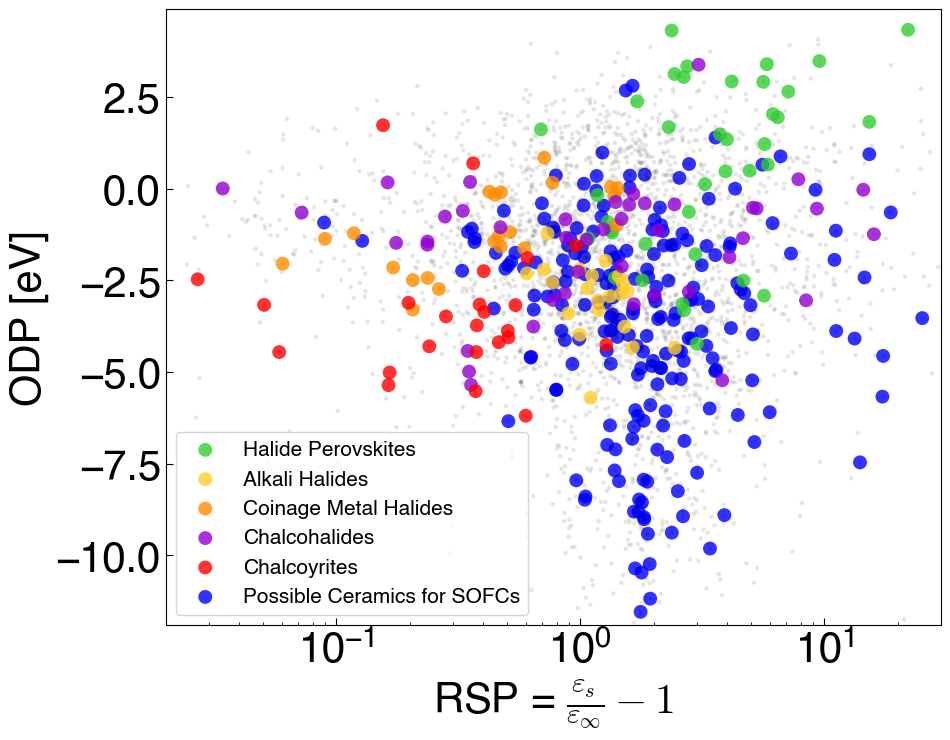

In [12]:
plt.figure(figsize=(10,8))
plt.scatter(df.e_ionic/df.e_electronic, df.ODP, color='black', alpha=0.1, marker='o', s=10, edgecolor='none')
a = df.loc[haps].copy()
b = df.loc[alkali_halides].copy()
c = df.loc[coinage_halides].copy()
d = df.loc[chalcohalides].copy()
e = df.loc[chalcopyrites].copy()
f = df.loc[CSOFCs].copy()

labels = ['Halide Perovskites', 'Alkali Halides', 'Coinage Metal Halides',
          'Chalcohalides', 'Chalcoyrites', 'Possible Ceramics for SOFCs']
cs = ['limegreen', '#FFCE2B', 'darkorange', 'darkviolet', 'red', 'blue']
alpha = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
darkcolors = ['']
markers = ['o', '^', '>', 'd', 'p', 'h']
for i, k in enumerate([a, b, c, d, e, f]):
    plt.scatter(k.e_ionic/k.e_electronic, k.ODP, s=100, alpha=alpha[i], label=labels[i], c=cs[i], marker='o', edgecolor='none', zorder=100*(int(i<5)))

plt.legend(fontsize=15, ncols=1, loc='lower left')
plt.xscale('log')
plt.tick_params(direction='in', length=5)
plt.tick_params(direction='in', which='both')
plt.xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\\infty}}-1$')
plt.ylabel('ODP [eV]')
plt.xlim([2e-2, 3e1])
plt.ylim([-11.9, 4.9])
plt.show()

In [13]:
def labeler(label):
    if '\n' in label:
        new_label = []
        for cat in label.split('\n'):
            if any(c.islower() for c in cat):
                new_label.append(cat[:2]+'$\\mathdefault{^{'+cat[2:]+'}}'+'$')
            else:
                new_label.append(cat[:1]+'$\\mathdefault{^{'+cat[1:]+'}}'+'$')
        return '\n'.join(new_label)
    else:
        cat=label
        if any(c.islower() for c in cat):
            return cat[:2]+'$\\mathdefault{^{'+cat[2:]+'}}'+'$'
        else:
            return cat[:1]+'$\\mathdefault{^{'+cat[1:]+'}}'+'$'

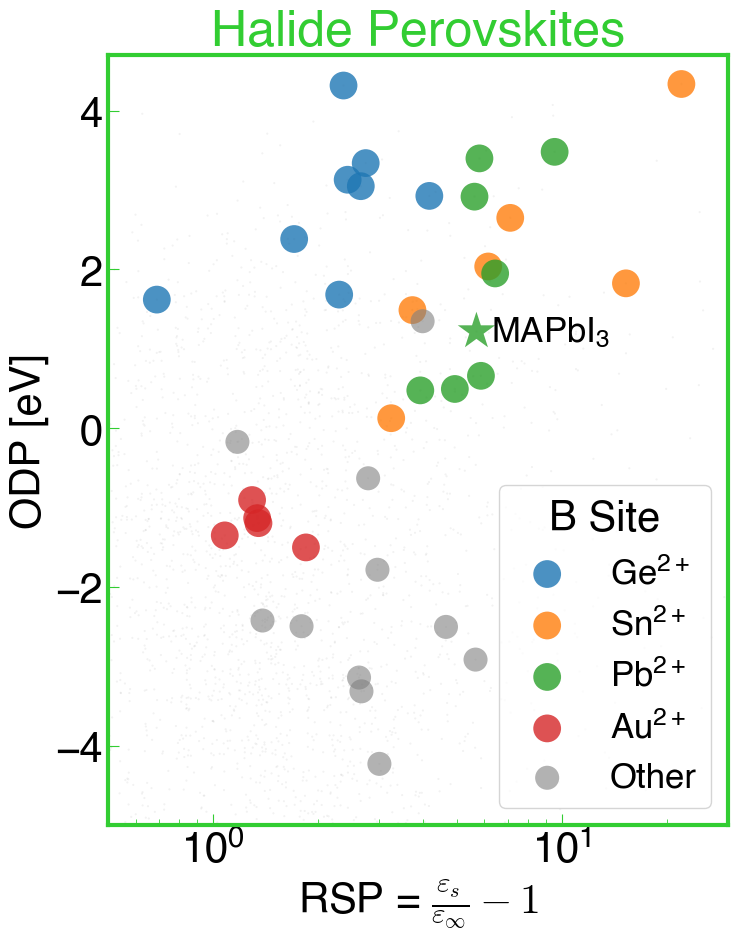

In [14]:
######### Figure 3b #########
plt.figure(figsize=(8,10))
ax = plt.axes()
ax.scatter(df.e_ionic/df.e_electronic, df.ODP, color='black', alpha=0.05, marker='.', s=10, edgecolor='none')

B_sites = {}
for index, row in a.iterrows():
    if row.e_ionic == row.e_ionic: #not NaN
        s = row.cation_coordination.split("'Octahedron'") #choosing the octahedral site as the B site
        if len(s)==2:
            B = s[0].split("'")[-2]
        else:
            B = tuple(set([ss.split("'")[-2] for ss in s[:-1]]))
            if len(B)==1:
                B = B[0]
            else: #'2 B sites'
                B = sorted(B, key=lambda a: int(a[-2]) if a[-2].isdigit() else 1)[-1] #choose the one with the highest oxidation state 
        B_sites[index] = B

j = 0
C = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
bsites = set(B_sites.values())

for B in ['Ge2+', 'Sn2+', 'Pb2+', 'Au2+'] + [a for a in bsites if a not in ['Au2+', 'Ge2+', 'Sn2+', 'Pb2+']]:
    if B==B:
        m = [i for i in B_sites.keys() if B_sites[i]==B]
        bm = a.loc[m]
        if B == 'Pb2+':
            bm_nMAPI = bm.loc[bm.chemical_formula!='CH3NH3PbI3']
            bm_MAPI = bm.loc[bm.chemical_formula=='CH3NH3PbI3']
            bm = bm_nMAPI
            ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=labeler(B), s=400,
                       alpha=0.8, marker='o', c=C[j], edgecolor='none')
            ax.scatter(bm_MAPI.e_ionic/bm_MAPI.e_electronic, bm_MAPI.ODP, s=800, alpha=0.8, marker='*', c=C[j], edgecolor='none')
            ax.annotate('MAPbI$\\mathdefault{_{3}}$', (bm_MAPI.e_ionic/bm_MAPI.e_electronic * 1.1, bm_MAPI.ODP), fontsize=25, ha='left', va='center')
            
        else:
            if B in ['Ge2+', 'Sn2+', 'Au2+']:
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=labeler(B), s=400, alpha=0.8, marker='o', c=C[j], edgecolor='none')
            else:
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, s=300, alpha=0.6, marker='o', c='gray', edgecolor='none')

        j+=1

        
ax.set_ylim([-5, 4.7])
ax.set_xlim([5e-1, 3e1])
ax.scatter(1e6, 1e6, s=300, alpha=0.6, marker='o', color='gray', label='Other', edgecolor='none')        
ax.legend(loc='lower right', title='B Site', ncols=1, fontsize=25)
ax.tick_params(direction='in', which='both', length=4, color='limegreen')
ax.tick_params(direction='in', length=8, color='limegreen')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
ax.set_title('Halide Perovskites', color='limegreen', fontweight='bold')
plt.setp(ax.spines.values(), lw=3, color='limegreen')
plt.show()

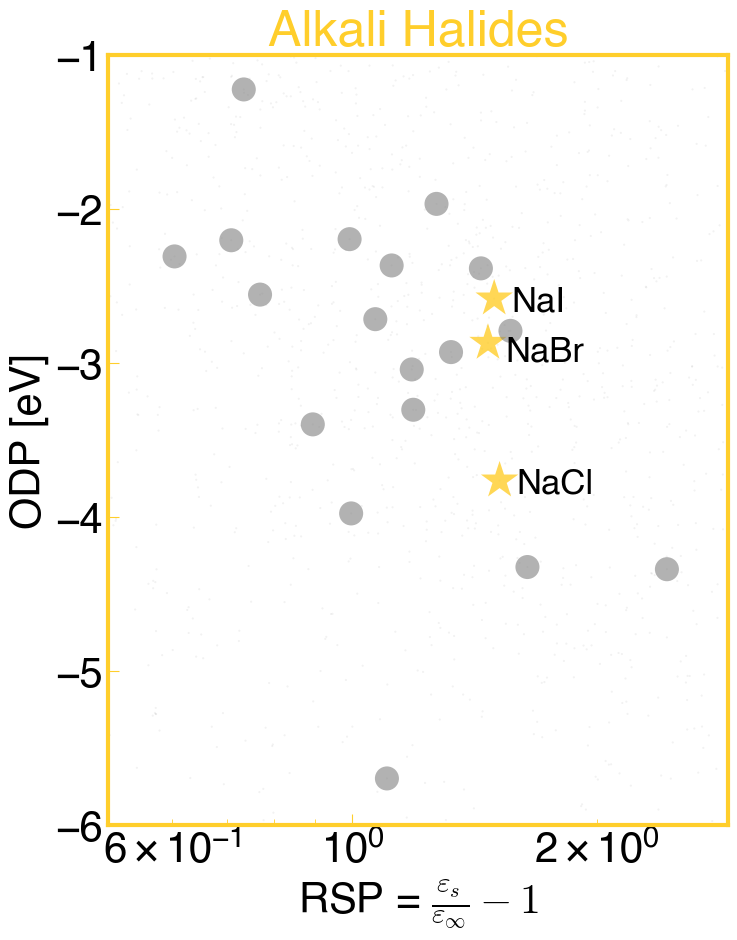

In [15]:
######### Figure 3c #########
plt.figure(figsize=(8,10))
ax = plt.axes()
ax.scatter(df.e_ionic/df.e_electronic, df.ODP, color='black', alpha=0.05, marker='.', s=10, edgecolor='none')

cations = {}
for index, row in b.iterrows():
    if row.e_ionic == row.e_ionic and row.cation_coordination == row.cation_coordination:
        cations[index] = tuple(set([a.replace('(','').replace("'",'')
                              for a in row.cation_coordination.split(', ')[::3]]))[0]
j=0
C = ['C0', 'C1', 'C2', 'C3', 'C4']
for B in ['Li+', 'Na+', 'K+', 'Rb+', 'Cs+']:
    if B==B:
        m = [i for i in cations.keys() if cations[i]==B]
        bm = b.loc[m]
        if B=='Na+':
            ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, s=800, alpha=0.8, marker='*', c='#FFCE2B', edgecolor='none')
            for index, row in bm.iterrows():
                ax.annotate(row.chemical_formula, 
                            (row.e_ionic/row.e_electronic*1.05, row.ODP-0.022*(1+1.6*int('Br' in row.chemical_formula))),
                             ha='left', va='center', fontsize=25)
        else:
            ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, s=300, alpha=0.6, marker='o', c='gray', edgecolor='none')
        
        j+=1
        
ax.set_ylim([-6, -1])
ax.set_xlim([5e-1, 2.9e0])

ax.tick_params(direction='in', which='both', length=4, color='#FFCE2B')
ax.tick_params(direction='in', length=8, color='#FFCE2B')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
plt.title('Alkali Halides', color='#FFCE2B')
plt.setp(ax.spines.values(), lw=3, color='#FFCE2B')
plt.show()

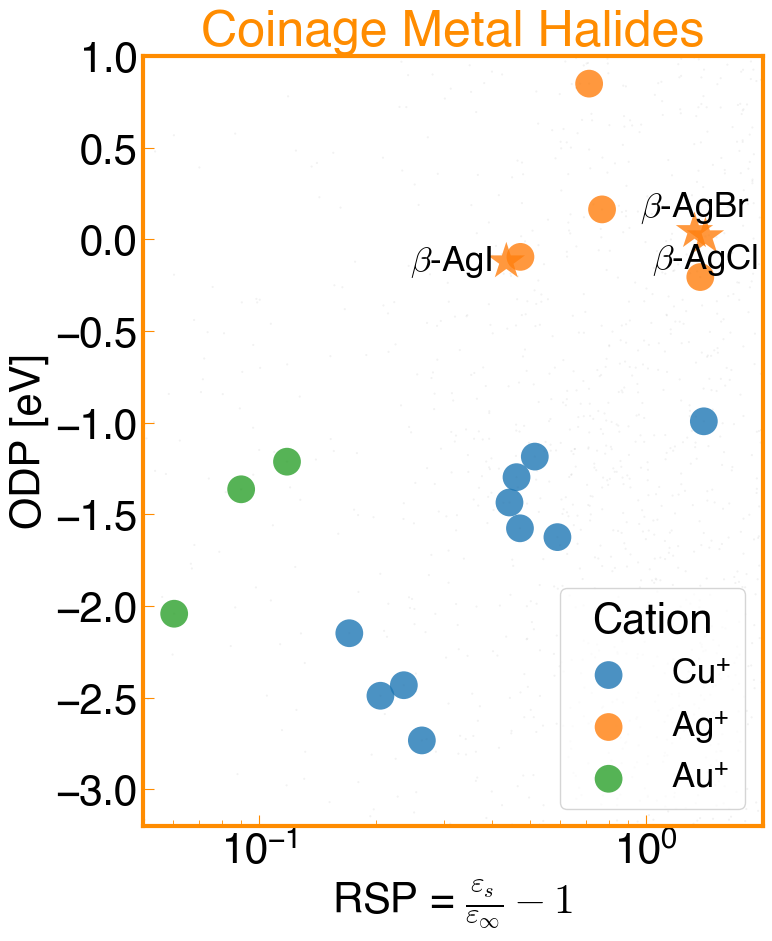

In [16]:
######### Figure 3d #########
plt.figure(figsize=(8,10))
ax = plt.axes()
ax.scatter(df.e_ionic/df.e_electronic, df.ODP, color='black', alpha=0.05, marker='.', s=10, edgecolor='none')

cations = {}
coords = {}
for index, row in c.iterrows():
    if row.e_ionic == row.e_ionic and row.cation_coordination == row.cation_coordination:
        if '3' not in row.chemical_formula: #AuCl3 cases with unique oxidation state and symmetry
            coords[index] = list(set([int(sst) for sst in row.cation_coordination if sst.isdigit()]))[0]
            cations[index] = tuple(set([a.replace('(','').replace("'",'')
                                        for a in row.cation_coordination.split(', ')[::3]]))[0]
j=0
for B in ['Cu+', 'Ag+', 'Au+']:
    if B==B:
        m = [i for i in cations.keys() if cations[i]==B]
        bm = c.loc[m]
        if B=='Ag+':
            bm_bAgI = bm.loc[bm.chemical_formula=='AgI'].loc[bm.space_group==186]
            bm_bAgBr = bm.loc[bm.chemical_formula=='AgBr'].loc[bm.space_group==225]
            bm_bAgCl = bm.loc[bm.chemical_formula=='AgCl'].loc[bm.space_group==225]
            bm_nbAgI = bm.drop(list(bm_bAgI.index)+list(bm_bAgBr.index)+list(bm_bAgCl.index))
            bm = bm_nbAgI
            ODP = bm_bAgI.ODP.mean()
            RSP = bm_bAgI.e_ionic.mean() / bm_bAgI.e_electronic.mean()
            plt.scatter(RSP, ODP, s=800, alpha=0.8, marker='*', color='C1', edgecolor='none')
            plt.annotate('$\\beta$-AgI', (RSP*0.92, ODP), fontsize=25, ha='right', va='center')
            plt.scatter(bm_bAgBr.e_ionic/bm_bAgBr.e_electronic, bm_bAgBr.ODP, s=800, alpha=0.8, marker='*', color='C1', edgecolor='none')
            plt.annotate('$\\beta$-AgBr', (bm_bAgBr.e_ionic/bm_bAgBr.e_electronic, bm_bAgBr.ODP+0.03), fontsize=25, ha='center', va='bottom')
            plt.scatter(bm_bAgCl.e_ionic/bm_bAgCl.e_electronic, bm_bAgCl.ODP, s=800, alpha=0.8, marker='*', color='C1', edgecolor='none')
            plt.annotate('$\\beta$-AgCl', (bm_bAgCl.e_ionic/bm_bAgCl.e_electronic, bm_bAgCl.ODP-0.03), fontsize=25, ha='center', va='top')
            plt.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=labeler(B), s=400, alpha=0.8, marker='o', edgecolor='none', c='C1')
        
        else:
            plt.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=labeler(B), s=400, alpha=0.8, marker='o', edgecolor='none', c=C[j])
        j+=1
        
ax.set_ylim([-3.2, 1])
ax.set_xlim([5e-2, 2e0])
ax.legend(title='Cation', loc='lower right', fontsize=25)
ax.tick_params(direction='in', which='both', length=4, color='darkorange')
ax.tick_params(direction='in', length=8, color='darkorange')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
plt.title('Coinage Metal Halides', color='darkorange')
plt.setp(ax.spines.values(), lw=3, color='darkorange')
plt.show()

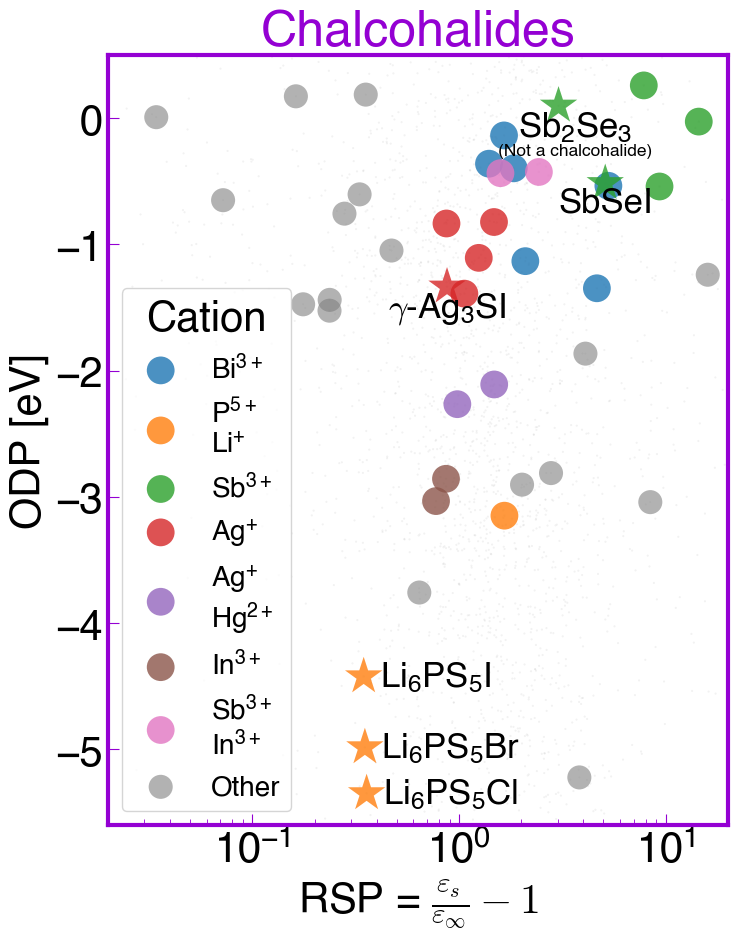

In [17]:
######### Figure 3e #########
plt.figure(figsize=(8,10))
ax = plt.axes()
ax.scatter(df.e_ionic/df.e_electronic, df.ODP, color='black', alpha=0.05, marker='.', s=10, edgecolor='none')

sb2se3 = df.loc[df.chemical_formula=='Sb2Se3']
ax.scatter(sb2se3.e_ionic/sb2se3.e_electronic, sb2se3.ODP, color='C2', alpha=0.8, marker='*', s=800, edgecolor='none')

ax.annotate('Sb$\\mathdefault{_{2}}$Se$\\mathdefault{_{3}}$', (sb2se3.e_ionic/sb2se3.e_electronic*1.2, sb2se3.ODP-0.3), fontsize=25, ha='center', va='bottom')
ax.annotate('(Not a chalcohalide)', (sb2se3.e_ionic/sb2se3.e_electronic*1.2, sb2se3.ODP-0.3), fontsize=12.5, ha='center', va='top')


cations = {}
for index, row in d.iterrows():
    if row.e_ionic == row.e_ionic and row.cation_coordination == row.cation_coordination:
        cats = tuple(set([a.replace('(','').replace("'",'')
                                    for a in row.cation_coordination.split(', ')[::3]]))
        if len(cats) > 1:
            cations[index] = '\n'.join(cats)
        else:
            cations[index] = cats[0]

j=0
singles = set([a for a in cations.values() if len(a.split('\n'))==1])
C = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17']
for B in ['Bi3+', 'P5+\nLi+', 'Sb3+', 'Ag+']+list(set([ccc for ccc in cations.values() if ccc not in ['Sb3+', 'Bi3+', 'P5+\nLi+', 'Ag+']])):
    if B==B:
        m = [i for i in cations.keys() if cations[i]==B]
        bm = d.loc[m]
        bm_SbSeI = bm.loc[bm.chemical_formula=='SbSeI']
        bm_gAg3SI = bm.loc[bm.chemical_formula=='Ag3SI'].loc[bm.space_group==146]
        bm_LiArgodyte = bm.loc[[i for i, r in bm.iterrows() if r.chemical_formula.startswith('Li6PS5')]]
        bm = bm.drop(list(bm_SbSeI.index)+list(bm_gAg3SI.index)+list(bm_LiArgodyte.index), axis=0)

        if B == 'Sb3+':
            ax.scatter(bm_SbSeI.e_ionic/bm_SbSeI.e_electronic, bm_SbSeI.ODP, s=800, alpha=0.8, marker='*', edgecolor='none', c=C[j])
            ax.annotate('SbSeI', (bm_SbSeI.e_ionic/bm_SbSeI.e_electronic, bm_SbSeI.ODP-0.025), ha='center', va='top', fontsize=25)

        if B == 'Ag+':
            ax.scatter(bm_gAg3SI.e_ionic/bm_gAg3SI.e_electronic, bm_gAg3SI.ODP, s=800, alpha=0.8, marker='*',  c=C[j], edgecolor='none')
            ax.annotate('$\\gamma$-Ag$\\mathdefault{_{3}}$SI',(bm_gAg3SI.e_ionic/bm_gAg3SI.e_electronic, bm_gAg3SI.ODP-0.025), ha='center', va='top', fontsize=25)

        if B == 'P5+\nLi+':
            ax.scatter(bm_LiArgodyte.e_ionic/bm_LiArgodyte.e_electronic, bm_LiArgodyte.ODP, s=800, alpha=0.8, marker='*',  c=C[j], edgecolor='none')
            for i, r in bm_LiArgodyte.iterrows():
                ax.annotate('Li$\\mathdefault{_{6}}$PS$\\mathdefault{_{5}}$'+r.chemical_formula.split('5')[-1],
                            (r.e_ionic/r.e_electronic*1.2, r.ODP), ha='left', va='center', fontsize=25)

        if B == 'P5+\nLi+' or (len(bm) > 2 or (len(B.split('\n'))==1 and len(bm)>1) or (any(k in B for k in singles) and len(bm)>1)) and ('Nb' not in B):
            ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=labeler(B), s=400, alpha=0.8, marker='o', edgecolor='none', c=C[j])
            j+=1

        else:
            ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, s=300, alpha=0.6, marker='o', color='gray', edgecolor='none')

            
ax.scatter(1e6, 1e6, s=300, alpha=0.6, marker='o', color='gray', label='Other', edgecolor='none')        
ax.set_ylim([-5.6, 0.5])
ax.set_xlim([2e-2, 2e1])
ax.legend(title='Cation', ncols=1, fontsize=20)
ax.tick_params(direction='in', which='both', length=4, color='darkviolet')
ax.tick_params(direction='in', length=8, color='darkviolet')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
plt.title('Chalcohalides', color='darkviolet')
plt.setp(ax.spines.values(), lw=3, color='darkviolet')
plt.show()

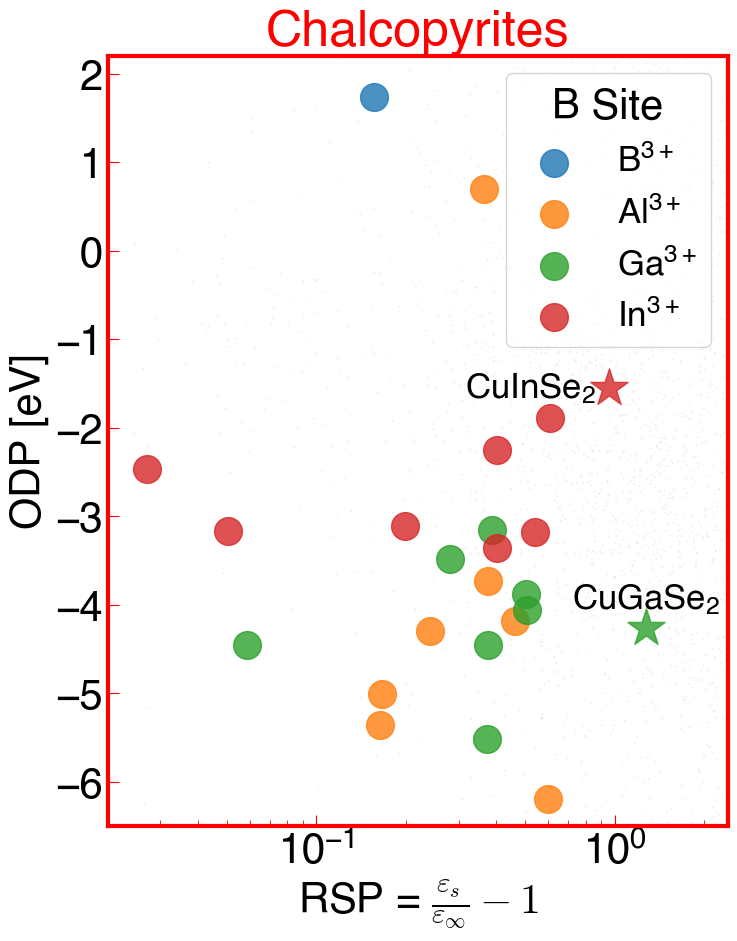

In [18]:
######### Figure 3f #########
plt.figure(figsize=(8,10))
ax = plt.axes()
ax.scatter(df.e_ionic/df.e_electronic, df.ODP, color='black', alpha=0.05, marker='.', s=10, edgecolor='none')

cations = {}
for index, row in e.iterrows():
    if row.e_ionic == row.e_ionic and row.cation_coordination == row.cation_coordination:
        cats = tuple(set([a.replace('(','').replace("'",'')
                                    for a in row.cation_coordination.split(', ')[::3]]))
        if len(cats) > 1:
            cations[index] = [c for c in cats if '3' in c or '4' in c][0]
        else:
            cations[index] = cats[0]

j=0
C = ['C0', 'C1', 'C2', 'C3']
for B in ['B3+', 'Al3+', 'Ga3+', 'In3+']:
    if B==B:
        m = [i for i in cations.keys() if cations[i]==B]
        bm = e.loc[m]
        if B=='In3+':
            bm_nCIS = bm.loc[bm.chemical_formula!='InCuSe2']
            bm_CIS = bm.loc[bm.chemical_formula=='InCuSe2']
            bm = bm_nCIS
            ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=labeler(B), s=400, alpha=0.8, marker='o', c=C[j])
            ax.scatter(bm_CIS.e_ionic/bm_CIS.e_electronic, bm_CIS.ODP, s=800, alpha=0.8, marker='*', c=C[j])
            ax.annotate('CuInSe$\\mathdefault{_{2}}$', (bm_CIS.e_ionic/bm_CIS.e_electronic*0.9, bm_CIS.ODP), fontsize=25, ha='right', va='center')
        elif B=='Ga3+':
            bm_nCGS = bm.loc[bm.chemical_formula!='GaCuSe2']
            bm_CGS = bm.loc[bm.chemical_formula=='GaCuSe2']
            bm = bm_nCGS
            ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=labeler(B), s=400, alpha=0.8, marker='o', c=C[j])
            ax.scatter(bm_CGS.e_ionic/bm_CGS.e_electronic, bm_CGS.ODP, s=800, alpha=0.8, marker='*', c=C[j])
            ax.annotate('CuGaSe$\\mathdefault{_{2}}$', (bm_CGS.e_ionic/bm_CGS.e_electronic, bm_CGS.ODP+0.125), fontsize=25, ha='center', va='bottom')

        else:
            ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=labeler(B), s=400*(1-0.25*int(bool(j>=4))), alpha=0.8, marker='o', c=C[j])
        j+=1

ax.set_ylim([-6.5, 2.2])
ax.set_xlim([2e-2, 2.4e0])
ax.legend(title='B Site', ncols=1, fontsize=25, loc='upper right')
ax.tick_params(direction='in', which='both', length=4, color='red')
ax.tick_params(direction='in', length=8, color='red')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
plt.title('Chalcopyrites', color='red')
plt.setp(ax.spines.values(), lw=3, color='red')
plt.show()

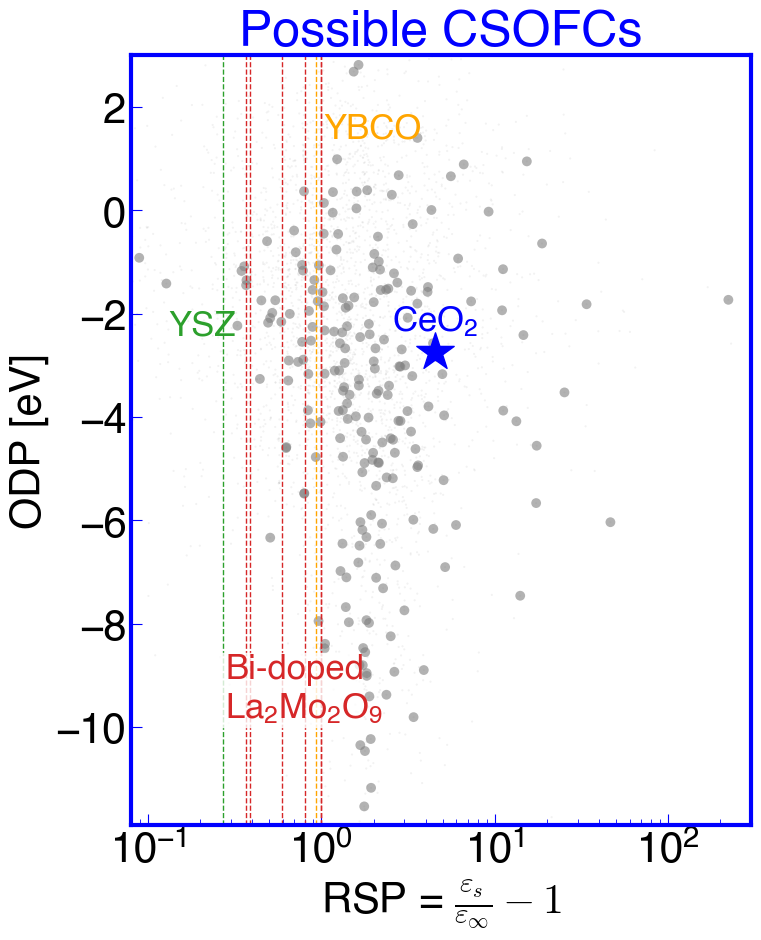

In [19]:
######### Figure 3g #########
plt.figure(figsize=(8,10))
plt.scatter(df.e_ionic/df.e_electronic, df.ODP, color='black', alpha=0.05, marker='.', s=10, edgecolor='none')
g = df.loc[CSOFCs]

ga = g.loc[g.chemical_formula!='CeO2']
ceo = g.loc[g.chemical_formula=='CeO2'].loc[g.space_group==225]

plt.scatter(ga.e_ionic/ga.e_electronic, ga.ODP, s=50, alpha=0.6, marker='o', c='gray', edgecolor='none')
plt.scatter(ceo.e_ionic/ceo.e_electronic, ceo.ODP, s=800, marker='*', c='blue')
plt.annotate('CeO$\\mathdefault{_{2}}$', (ceo.e_ionic/ceo.e_electronic, ceo.ODP+0.28),
             fontsize=25, ha='center', va='bottom', c='blue')
YSZ = df.loc[df.chemical_formula=='8YSZ']
plt.axvline(list(YSZ.e_ionic/YSZ.e_electronic)[0], linestyle='--', color='C2', linewidth=1)
plt.annotate('YSZ', (YSZ.e_ionic/YSZ.e_electronic*0.48, -2.4), fontsize=25, c='C2')

BYCO = df.loc[df.chemical_formula=='Ba2YCu3O7']
plt.axvline(list(BYCO.e_ionic/BYCO.e_electronic)[0], linestyle='--', color='orange', linewidth=1)
plt.annotate('YBCO', (list(BYCO.e_ionic/BYCO.e_electronic)[0]*1.1, 1.4), fontsize=25, c='orange')

#Bi-doped La2Mo2O9
Bi_doped_La2Mo2O9 = df.loc[[i for i,r in df.iterrows() if 'La1.' in r.chemical_formula or r.chemical_formula=='La2Mo2O9']]
for ei, ee in zip(Bi_doped_La2Mo2O9.e_ionic, Bi_doped_La2Mo2O9.e_electronic):
    plt.axvline(ei/ee, linestyle='--', color='C3', linewidth=1)
    
rect = patches.Rectangle((2.5e-1,-10), 1.425, 1.425, color='white', edgecolor='none', alpha=0.8, zorder=1000)
plt.gca().add_patch(rect)
plt.annotate('Bi-doped\nLa$\\mathdefault{_{2}}$Mo$\\mathdefault{_{2}}$O$\\mathdefault{_{9}}$',
             (0.28, -9.8), fontsize=25, c='C3', zorder=10000)

plt.xlim([8e-2, 3e2])
plt.ylim([-11.9, 3])
plt.tick_params(direction='in', which='both', length=4, color='blue')
plt.tick_params(direction='in', length=8, color='blue')
plt.xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
plt.ylabel('ODP [eV]')
plt.xscale('log')
plt.title('Possible CSOFCs', color='blue')
plt.setp(plt.gca().spines.values(), lw=3, color='blue')
plt.show()

# Figure 5: Hardness-RSP

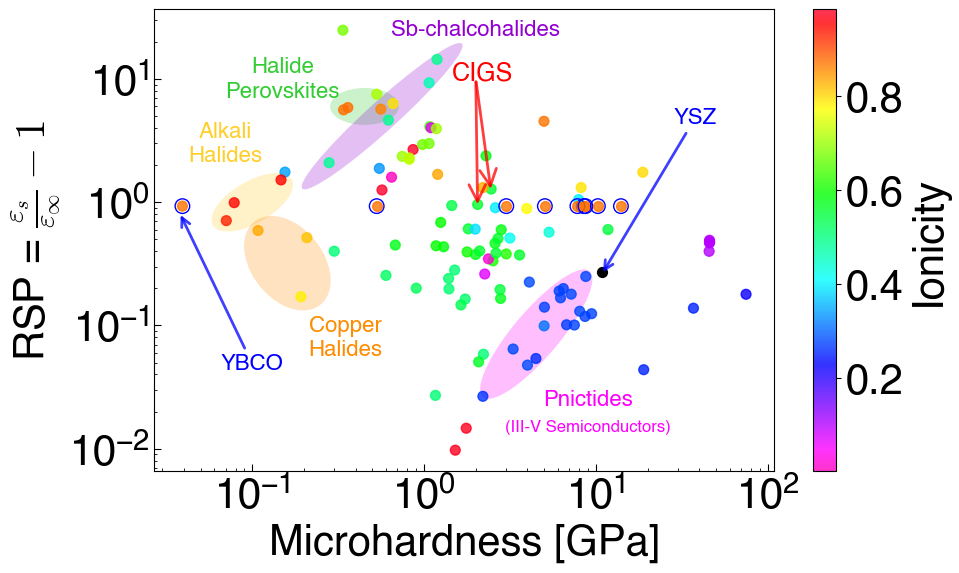

In [20]:
plt.figure(figsize=(10,6))
fi_df = df.loc[[i for i, r in df.iterrows() if r.ionicity<=1 and r.hardness>1e-2 or any(a in r.chemical_formula for a in ['YSZ', 'La1.'])]]

norm = colors.Normalize(vmin=fi_df.ionicity.min(), vmax=fi_df.ionicity.max())
cmap = cm.get_cmap('gist_rainbow_r')

YBCO_entry = fi_df.loc[fi_df.chemical_formula=='Ba2YCu3O7']

plt.scatter(YBCO_entry.hardness, YBCO_entry.e_ionic/YBCO_entry.e_electronic, s=110, color='none', edgecolor='blue')
plt.scatter(fi_df.hardness, fi_df.e_ionic/fi_df.e_electronic, c=fi_df.ionicity, s=50, cmap=cmap, alpha=0.8, norm=norm)
for val in [(5.4+5+5.1+4.7)/4, 8.5, 0.53, 7.81, 8.7, 3.01, 10.28, 14]:
    plt.scatter(val, YBCO_entry.e_ionic/YBCO_entry.e_electronic, s=110, color='none', edgecolor='blue')
    plt.scatter(val, YBCO_entry.e_ionic/YBCO_entry.e_electronic, c=YBCO_entry.ionicity, s=50, alpha=0.8, cmap=cmap, norm=norm)

plt.colorbar(label='Ionicity')
ysz = fi_df.loc[fi_df.chemical_formula=='8YSZ']
plt.scatter(ysz.hardness[0], list(ysz.e_ionic/ysz.e_electronic)[0], s=50, color='black')

cis = fi_df.loc[fi_df.chemical_formula=='InCuSe2']
cgs = fi_df.loc[fi_df.chemical_formula=='GaCuSe2']

plt.annotate('', xy=(cis.hardness, cis.e_ionic/cis.e_electronic*0.95), xytext=(2, 10),
                arrowprops=dict(color='red', arrowstyle='->', linewidth=2, alpha=.75))
plt.annotate('', xy=(cgs.hardness, cgs.e_ionic/cgs.e_electronic*0.95), xytext=(2, 10),
                arrowprops=dict(color='red', arrowstyle='->', linewidth=2, alpha=.75))
plt.annotate('CIGS', (2.2,9), ha='center', va='bottom', fontsize=18, c='red')


plt.annotate('YSZ', xy=(ysz.hardness[0], list(ysz.e_ionic/ysz.e_electronic)[0]*0.95), xytext=(38, 4),
                arrowprops=dict(color='blue', arrowstyle='->', linewidth=2, alpha=.75), ha='center', va='bottom', fontsize=16, c='blue')

plt.annotate('YBCO', xy=(YBCO_entry.hardness*0.96, YBCO_entry.e_ionic/YBCO_entry.e_electronic*0.89), xytext=(1e-1, 4e-2),
                arrowprops=dict(color='blue', arrowstyle='->', linewidth=2, alpha=.75), ha='center', va='bottom', fontsize=16, c='blue')

plt.annotate('Pnictides', (9e0, 2.5e-2), fontsize=16, color='fuchsia', ha='center', va='center')
plt.annotate('(III-V Semiconductors)', (9e0, 1.5e-2), fontsize=12, color='fuchsia', ha='center', va='center')
ell_tform = ScaledTranslation(4.5e0, 8.5e-2, plt.gca().transScale) + plt.gca().transLimits + plt.gca().transAxes
el1 = patches.Ellipse(xy=(0, 0), width=1.2, height=3e-1, angle=60, facecolor='fuchsia', alpha=.25, edgecolor='none', transform=ell_tform, zorder=-100)

plt.annotate('Halide\nPerovskites', (1.5e-1, 1e1), ha='center', va='center', fontsize=16, color='limegreen')
ell_tform = ScaledTranslation(4.5e-1, 6e0, plt.gca().transScale) + plt.gca().transLimits + plt.gca().transAxes
el2 = patches.Ellipse(xy=(0, 0), width=4e-1, height=3e-1, angle=0, facecolor='limegreen', alpha=.25, edgecolor='none', transform=ell_tform, zorder=-100)

plt.annotate('Alkali\nHalides', (7e-2, 3e0), ha='center', va='center', fontsize=16, color='#FFCE2B')
ell_tform = ScaledTranslation(1e-1, 1, plt.gca().transScale) + plt.gca().transLimits + plt.gca().transAxes
el3 = patches.Ellipse(xy=(0, 0), width=6e-1, height=3e-1, angle=45, facecolor='#FFCE2B', alpha=.25, edgecolor='none', transform=ell_tform, zorder=-100)

plt.annotate('Copper\nHalides', (3.5e-1, 8e-2), ha='center', va='center', fontsize=16, color='darkorange')
ell_tform = ScaledTranslation(1.6e-1, 3.2e-1, plt.gca().transScale) + plt.gca().transLimits + plt.gca().transAxes
el4 = patches.Ellipse(xy=(0, 0), width=4.5e-1, height=8e-1, angle=20, facecolor='darkorange', alpha=.25, edgecolor='none', transform=ell_tform, zorder=-100)

plt.annotate('Sb-chalcohalides', (2e0, 2.5e1), ha='center', va='center', fontsize=16, color='darkviolet')
ell_tform = ScaledTranslation(5.7e-1, 5e0, plt.gca().transScale) + plt.gca().transLimits + plt.gca().transAxes
el5 = patches.Ellipse(xy=(0, 0), width=2e-1, height=1.5e0, angle=-38, facecolor='darkviolet', alpha=.25, edgecolor='none', transform=ell_tform, zorder=-100)

for ellipse in [el1, el2, el3, el4, el5]:
    plt.gca().add_patch(ellipse)

plt.ylabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
plt.xlabel('Microhardness [GPa]')
plt.xscale('log')
plt.yscale('log')
plt.tick_params(direction='in', length=5)
plt.tick_params(direction='in', which='both')
plt.show()

# SI Figures: RSP measured vs. computed

In [21]:
rsp_adf = adf.copy()
rsp_adf = rsp_adf.dropna(subset=['RSP_ref'])
rsp_adf['RSP_theoretical'] = [int('Materials Project' in r.RSP_ref) for i, r in rsp_adf.iterrows()]
rsp_df = rsp_adf.groupby(['chemical_formula', 'space_group', 'cation_coordination']).mean(numeric_only=True).reset_index()

In [22]:
rsp_df.RSP_theoretical.unique() # there's one case of multiple RSP from different sources - SiC (with tag=0.25).

array([0.  , 1.  , 0.25])

In [23]:
haps = [] #Halide Perovskites (green)
alkali_halides = [] #Alkali Halides (yellow)
coinage_halides = [] #Coinage Halides (orange)
chalcohalides = [] #Chalcohalides (purple)
chalcopyrites = [] #Chalcopyrites (red)
CSOFCs = [] #Ceramics for solid oxide fuel cells (blue)

for index, row in rsp_df.iterrows():
    if 'YSZ' in row.chemical_formula or 'La1.' in row.chemical_formula:
        CSOFCs.append(index)
        continue
        
    comp = Composition(row.chemical_formula)
    elements = list(comp.as_dict().keys())
    raw_cations = [a.split("', '")[0].replace("'", '').replace('(', '').replace('+', '')
                   for a in row.cation_coordination.split("), (")]
    cations = [''.join(c for c in cat if not c.isdigit()) for cat in raw_cations] #species
    cations = list(set(cations))
    ox_cations = []#species+state
    for cat in raw_cations: 
        if cat[-1].isdigit():
            ox_cations.append(cat)
        else:
            ox_cations.append(cat+'1')
    ox_cations = list(set(ox_cations))
    anions = [an for an in elements if an not in cations] #species


    #Halide Perovskites#
    #Definition is based on composition - ABX3 (including A being MA).
    if (any([x in anions for x in ['Cl', 'Br', 'I']]) and len(comp)>=3 and 'Octahedron' in str(row.cation_coordination) and
        all([comp[x]==3 for x in [x for x in ['Cl', 'Br', 'I'] if x in comp]]) and
        all([comp[x]==1 or comp[x]==6 for x in [x for x in comp.as_dict().keys() if x not in ['Cl', 'Br', 'I']]])):
        if row.chemical_formula not in ['CaInBr3', 'CaTlCl3', 'CaTlBr3']: #proved to not be a perovskite
            haps.append(index)

    #Alkali Halides#
    #Definition is based on composition - alkali metal and an halide 
    if (any([x in anions for x in ['Cl', 'Br', 'I']]) and any([x in comp for x in ['Li', 'Na', 'K', 'Rb', 'Cs']])
        and len(comp)==2):
        alkali_halides.append(index)

    #Coinage Halides#
    #Definition is based on composition - coinage metal and an halide 
    if (any([x in anions for x in ['Cl', 'Br', 'I']]) and any([x in comp for x in ['Cu', 'Ag', 'Au']])
        and len(comp)==2):
        coinage_halides.append(index)

    #Chalcohalides#
    #Definition is based on composition - halide and chalcogenide (anions!)
    if any([x in anions for x in ['Cl', 'Br', 'I']]) and any([x in comp for x in ['S', 'Se', 'Te']]) and len(comp)>2:
        if row.cation_coordination==row.cation_coordination:
            if all([all([x!=''.join(aa for aa in a.split("'")[1] if not aa.isdigit())[:-1]
                         for a in row.cation_coordination.split(', ')[::3]])
                   for x in ['S', 'Se', 'Te']]): #those are not cations
                chalcohalides.append(index)

    #Chalcopyrites#
    #Definition is based on composition (ABX2) and structure (space group 122).
    if (row.space_group == 122 and len(comp)==3):
        chalcs = [x for x in anions if str(x) in ['S', 'Se', 'Te']]
        if len(chalcs)==1:
            if all([comp[chalcs[0]]==2*comp[x] for x in comp if str(x) not in ['S', 'Se', 'Te']]):
                chalcopyrites.append(index)

    #Possible CSOFCs#
    #Definition is based on estimated energy of vacancy formation
    if anions==['O']:
        Evacs = []
        weights = []
        if all([cat in evac.atom.tolist() for cat in cations]): #First, we can say something about the atom
            for cat in cations:
                if len(cat)==2: #2-letter element
                    ox = [a[-1] for a in ox_cations if cat==a[:2]]
                else: #1-letter element
                    ox = [a[-1] for a in ox_cations if len(a)==2 and cat==a[0]]
                ox = list(set(ox)) #all ox states of atom
                if len(ox)>=2: #more than two- we add automatically to not lose a point
                    CSOFCs.append(index)
                elif len(ox)>0: #there is any
                    ox = int(ox[0])
                    Evac_val = evac.loc[evac.atom==cat].loc[evac.oxidation_state==ox].Evac.tolist()
                    if len(Evac_val)>0:
                        Evacs.append(comp[cat]*float(Evac_val[0])) #Evac of atom
                        weights.append(comp[cat])
            if len(Evacs)>0:
                if np.sum(Evacs)>2*sum(weights) and np.sum(Evacs)<5*sum(weights): #weighted average
                    CSOFCs.append(index)

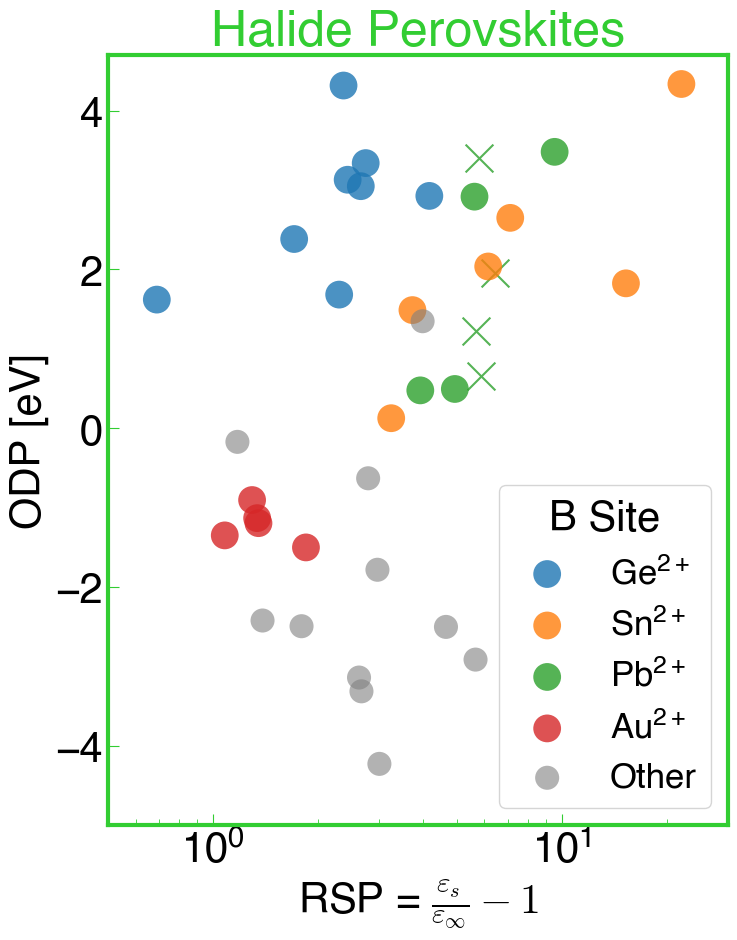

In [24]:
plt.figure(figsize=(8,10))
ax = plt.axes()

a = rsp_df.loc[haps]
a_exp = a.loc[a.RSP_theoretical == 0]
a_the = a.loc[a.RSP_theoretical == 1]

for tag, a in enumerate([a_exp, a_the]):
    B_sites = {}
    for index, row in a.iterrows():
        if row.e_ionic == row.e_ionic: #not NaN
            s = row.cation_coordination.split("'Octahedron'") #choosing the octahedral site as the B site
            if len(s)==2:
                B = s[0].split("'")[-2]
            else:
                B = tuple(set([ss.split("'")[-2] for ss in s[:-1]]))
                if len(B)==1:
                    B = B[0]
                else: #'2 B sites'
                    B = sorted(B, key=lambda a: int(a[-2]) if a[-2].isdigit() else 1)[-1] #choose the one with the highest oxidation state 
            B_sites[index] = B
    
    j = 0
    C = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
    bsites = set(B_sites.values())

    for B in ['Ge2+', 'Sn2+', 'Pb2+', 'Au2+'] + [a for a in bsites if a not in ['Au2+', 'Ge2+', 'Sn2+', 'Pb2+']]:
        if B==B:
            m = [i for i in B_sites.keys() if B_sites[i]==B]
            bm = a.loc[m]
            if B == 'Pb2+':
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=['', labeler(B)][tag], s=400,
                           alpha=0.8, marker=['x', 'o'][tag], c=C[j], edgecolor='none')
                
            else:
                if B in ['Ge2+', 'Sn2+', 'Au2+']:
                    ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=['', labeler(B)][tag], s=400, alpha=0.8, marker=['x', 'o'][tag], c=C[j], edgecolor='none')
                else:
                    ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, s=300, alpha=0.6, marker='o', c='gray', edgecolor='none')
    
            j+=1

        
ax.set_ylim([-5, 4.7])
ax.set_xlim([5e-1, 3e1])
ax.scatter(1e6, 1e6, s=300, alpha=0.6, marker='o', color='gray', label='Other', edgecolor='none')        
ax.legend(loc='lower right', title='B Site', ncols=1, fontsize=25)
ax.tick_params(direction='in', which='both', length=4, color='limegreen')
ax.tick_params(direction='in', length=8, color='limegreen')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
ax.set_title('Halide Perovskites', color='limegreen', fontweight='bold')
plt.setp(ax.spines.values(), lw=3, color='limegreen')
plt.show()

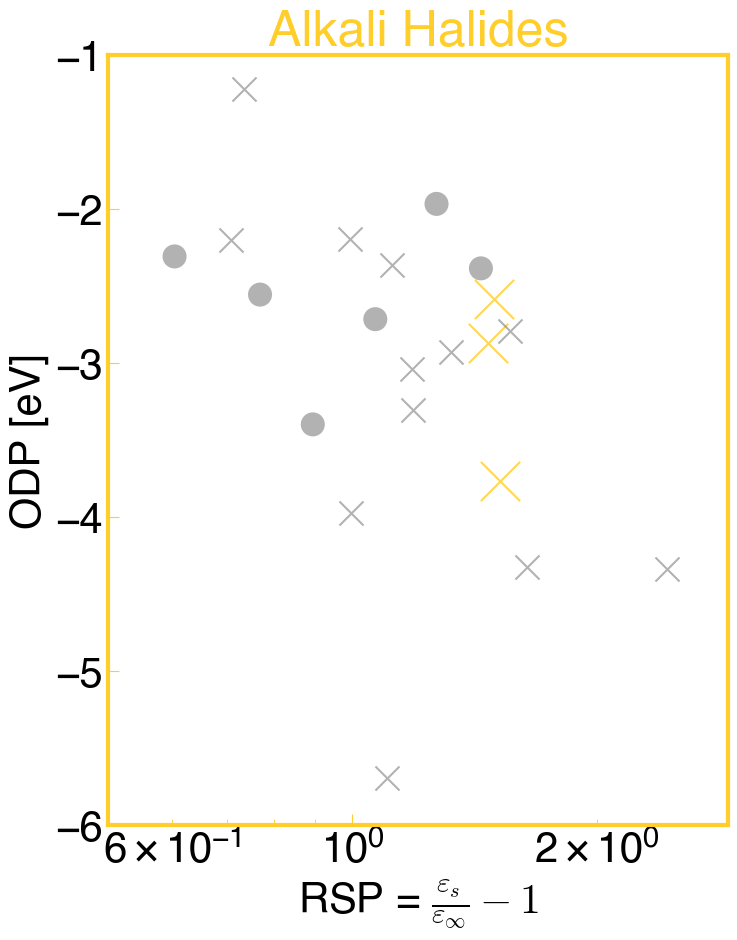

In [25]:
plt.figure(figsize=(8,10))
ax = plt.axes()

b = rsp_df.loc[alkali_halides]
b_exp = b.loc[b.RSP_theoretical==0]
b_the = b.loc[b.RSP_theoretical==1]

for tag, b in enumerate([b_exp, b_the]):
    cations = {}
    for index, row in b.iterrows():
        if row.e_ionic == row.e_ionic and row.cation_coordination == row.cation_coordination:
            cations[index] = tuple(set([a.replace('(','').replace("'",'')
                                  for a in row.cation_coordination.split(', ')[::3]]))[0]
    j=0
    C = ['C0', 'C1', 'C2', 'C3', 'C4']
    for B in ['Li+', 'Na+', 'K+', 'Rb+', 'Cs+']:
        if B==B:
            m = [i for i in cations.keys() if cations[i]==B]
            bm = b.loc[m]
            if B=='Na+':
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, s=800, alpha=0.8, marker=['x', 'o'][tag], c='#FFCE2B', edgecolor='none')
            else:
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, s=300, alpha=0.6, marker=['x', 'o'][tag], c='gray', edgecolor='none')        
            j+=1
            
ax.set_ylim([-6, -1])
ax.set_xlim([5e-1, 2.9e0])

ax.tick_params(direction='in', which='both', length=4, color='#FFCE2B')
ax.tick_params(direction='in', length=8, color='#FFCE2B')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
plt.title('Alkali Halides', color='#FFCE2B')
plt.setp(ax.spines.values(), lw=3, color='#FFCE2B')
plt.show()

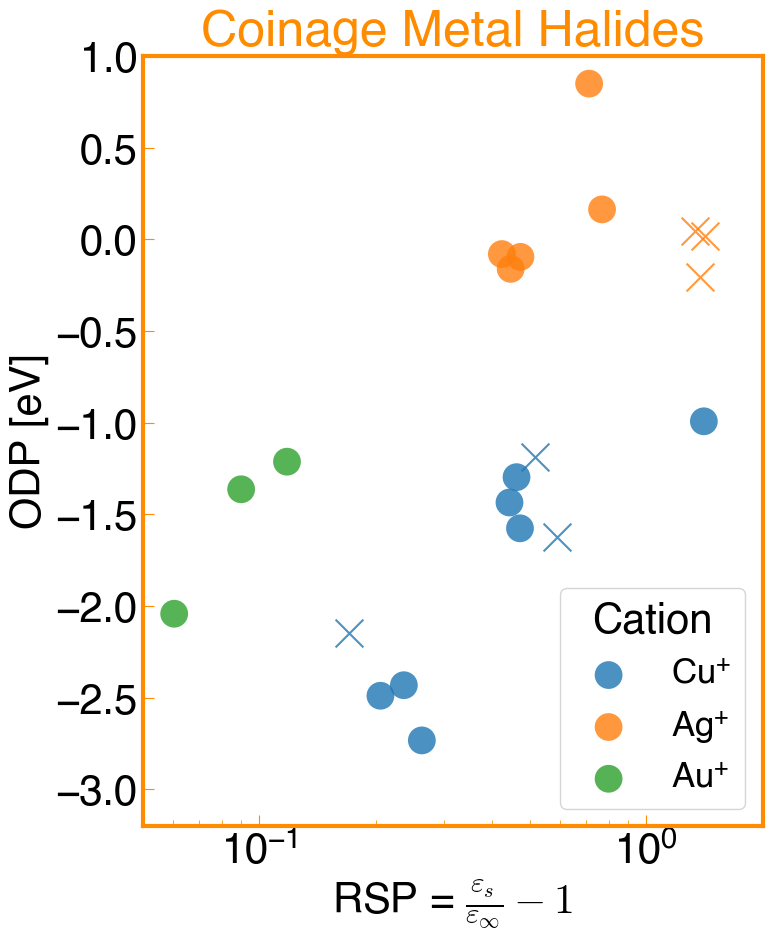

In [26]:
plt.figure(figsize=(8,10))
ax = plt.axes()

c = rsp_df.loc[coinage_halides]
c_exp = c.loc[c.RSP_theoretical==0]
c_the = c.loc[c.RSP_theoretical==1]

for tag, c in enumerate([c_exp, c_the]):    
    cations = {}
    coords = {}
    for index, row in c.iterrows():
        if row.e_ionic == row.e_ionic and row.cation_coordination == row.cation_coordination:
            if '3' not in row.chemical_formula: #AuCl3 cases with unique oxidation state and symmetry
                coords[index] = list(set([int(sst) for sst in row.cation_coordination if sst.isdigit()]))[0]
                cations[index] = tuple(set([a.replace('(','').replace("'",'')
                                            for a in row.cation_coordination.split(', ')[::3]]))[0]
    j=0
    for B in ['Cu+', 'Ag+', 'Au+']:
        if B==B:
            m = [i for i in cations.keys() if cations[i]==B]
            bm = c.loc[m]
            if B=='Ag+':
                plt.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=['', labeler(B)][tag], s=400, alpha=0.8, marker=['x', 'o'][tag], edgecolor='none', c='C1')
            
            else:
                plt.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=['', labeler(B)][tag], s=400, alpha=0.8, marker=['x', 'o'][tag], edgecolor='none', c=C[j])
            j+=1
            
ax.set_ylim([-3.2, 1])
ax.set_xlim([5e-2, 2e0])
ax.legend(title='Cation', loc='lower right', fontsize=25)
ax.tick_params(direction='in', which='both', length=4, color='darkorange')
ax.tick_params(direction='in', length=8, color='darkorange')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
plt.title('Coinage Metal Halides', color='darkorange')
plt.setp(ax.spines.values(), lw=3, color='darkorange')
plt.show()

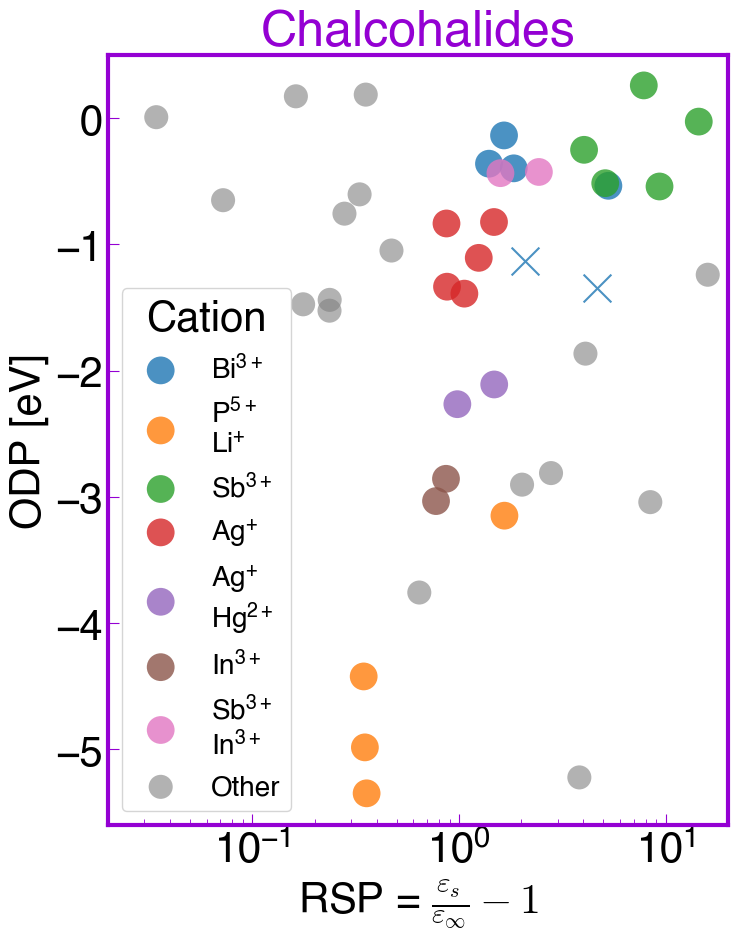

In [27]:
plt.figure(figsize=(8,10))
ax = plt.axes()

sb2s3 = rsp_df.loc[rsp_df.chemical_formula=='Sb2S3']
ax.scatter(sb2s3.e_ionic/sb2s3.e_electronic, sb2s3.ODP, color='C2', alpha=0.8, marker=['x', 'o'][tag], s=400, edgecolor='none')

d = rsp_df.loc[chalcohalides]
d_exp = d.loc[d.RSP_theoretical==0]
d_the = d.loc[d.RSP_theoretical==1]

for tag, d in enumerate([d_exp, d_the]):
    cations = {}
    for index, row in d.iterrows():
        if row.e_ionic == row.e_ionic and row.cation_coordination == row.cation_coordination:
            cats = tuple(set([a.replace('(','').replace("'",'')
                                        for a in row.cation_coordination.split(', ')[::3]]))
            if len(cats) > 1:
                cations[index] = '\n'.join(cats)
            else:
                cations[index] = cats[0]
    j=0
    singles = set([a for a in cations.values() if len(a.split('\n'))==1])
    C = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17']
    for B in ['Bi3+', 'P5+\nLi+', 'Sb3+', 'Ag+']+list(set([ccc for ccc in cations.values() if ccc not in ['Sb3+', 'Bi3+', 'P5+\nLi+', 'Ag+']])):
        if B==B:
            m = [i for i in cations.keys() if cations[i]==B]
            bm = d.loc[m]
            bm_SbSeI = bm.loc[bm.chemical_formula=='SbSeI']
            bm_gAg3SI = bm.loc[bm.chemical_formula=='Ag3SI'].loc[bm.space_group==146]
            bm_LiArgodyte = bm.loc[[i for i, r in bm.iterrows() if r.chemical_formula.startswith('Li6PS5')]]
            bm = bm.drop(list(bm_SbSeI.index)+list(bm_gAg3SI.index)+list(bm_LiArgodyte.index), axis=0)
    
            if B == 'Sb3+':
                ax.scatter(bm_SbSeI.e_ionic/bm_SbSeI.e_electronic, bm_SbSeI.ODP, s=400, alpha=0.8, marker=['x', 'o'][tag], edgecolor='none', c=C[j])    
            if B == 'Ag+':
                ax.scatter(bm_gAg3SI.e_ionic/bm_gAg3SI.e_electronic, bm_gAg3SI.ODP, s=400, alpha=0.8, marker=['x', 'o'][tag],  c=C[j], edgecolor='none')    
            if B == 'P5+\nLi+':
                ax.scatter(bm_LiArgodyte.e_ionic/bm_LiArgodyte.e_electronic, bm_LiArgodyte.ODP, s=400, alpha=0.8, marker=['x', 'o'][tag],  c=C[j], edgecolor='none')
            if B == 'P5+\nLi+' or (len(bm) > 2 or (len(B.split('\n'))==1 and len(bm)>1) or (any(k in B for k in singles) and len(bm)>1)) and ('Nb' not in B):
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, label=['', labeler(B)][tag], s=400, alpha=0.8, marker=['x', 'o'][tag], edgecolor='none', c=C[j])
                j+=1
            else:
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP, s=300, alpha=0.6, marker=['x', 'o'][tag], color='gray', edgecolor='none')

            
ax.scatter(1e6, 1e6, s=300, alpha=0.6, marker='o', color='gray', label='Other', edgecolor='none')        
ax.set_ylim([-5.6, 0.5])
ax.set_xlim([2e-2, 2e1])
ax.legend(title='Cation', ncols=1, fontsize=20)
ax.tick_params(direction='in', which='both', length=4, color='darkviolet')
ax.tick_params(direction='in', length=8, color='darkviolet')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
plt.title('Chalcohalides', color='darkviolet')
plt.setp(ax.spines.values(), lw=3, color='darkviolet')
plt.show()

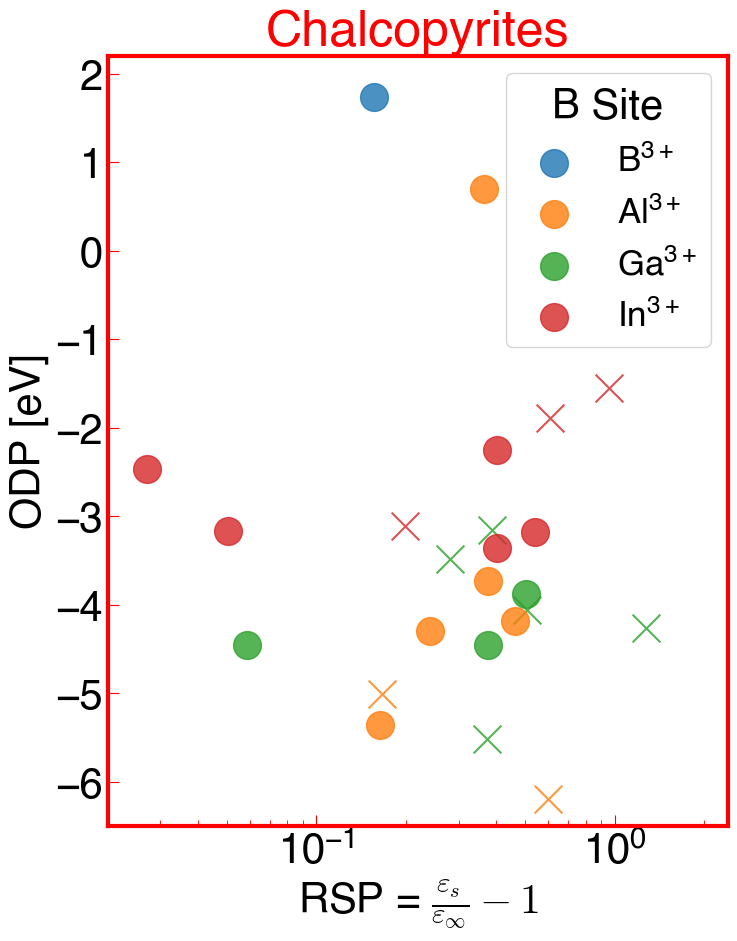

In [28]:
plt.figure(figsize=(8,10))
ax = plt.axes()

e = rsp_df.loc[chalcopyrites]
e_exp = e.loc[e.RSP_theoretical == 0]
e_the = e.loc[e.RSP_theoretical == 1]

for tag, e in enumerate([e_exp, e_the]):
    cations = {}
    for index, row in e.iterrows():
        if row.e_ionic == row.e_ionic and row.cation_coordination == row.cation_coordination:
            cats = tuple(set([a.replace('(','').replace("'",'')
                                        for a in row.cation_coordination.split(', ')[::3]]))
            if len(cats) > 1:
                cations[index] = [c for c in cats if '3' in c or '4' in c][0]
            else:
                cations[index] = cats[0]
    j=0
    C = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    for B in ['B3+', 'Al3+', 'Ga3+', 'In3+']:
        if B==B:
            m = [i for i in cations.keys() if cations[i]==B]
            bm = e.loc[m]
            if B=='In3+':
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP,
                           label=['', labeler(B)][tag], s=400, alpha=0.8, marker=['x', 'o'][tag], c=C[j])
            elif B=='Ga3+':
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP,
                           label=['', labeler(B)][tag], s=400, alpha=0.8, marker=['x', 'o'][tag], c=C[j])
            elif B=='Al3+': 
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP,
                           label=['', labeler(B)][tag], s=400, alpha=0.8, marker=['x', 'o'][tag], c=C[j])
            else:
                ax.scatter(bm.e_ionic/bm.e_electronic, bm.ODP,
                           label=['', labeler(B)][tag], s=400*(1-0.25*int(bool(j>=4))), alpha=0.8, marker=['x', 'o'][tag], c=C[j])
            j+=1

ax.set_ylim([-6.5, 2.2])
ax.set_xlim([2e-2, 2.4e0])
ax.legend(title='B Site', ncols=1, fontsize=25)
ax.tick_params(direction='in', which='both', length=4, color='red')
ax.tick_params(direction='in', length=8, color='red')
ax.set_xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
ax.set_ylabel('ODP [eV]')
ax.set_xscale('log')
plt.title('Chalcopyrites', color='red')
plt.setp(ax.spines.values(), lw=3, color='red')
plt.show()

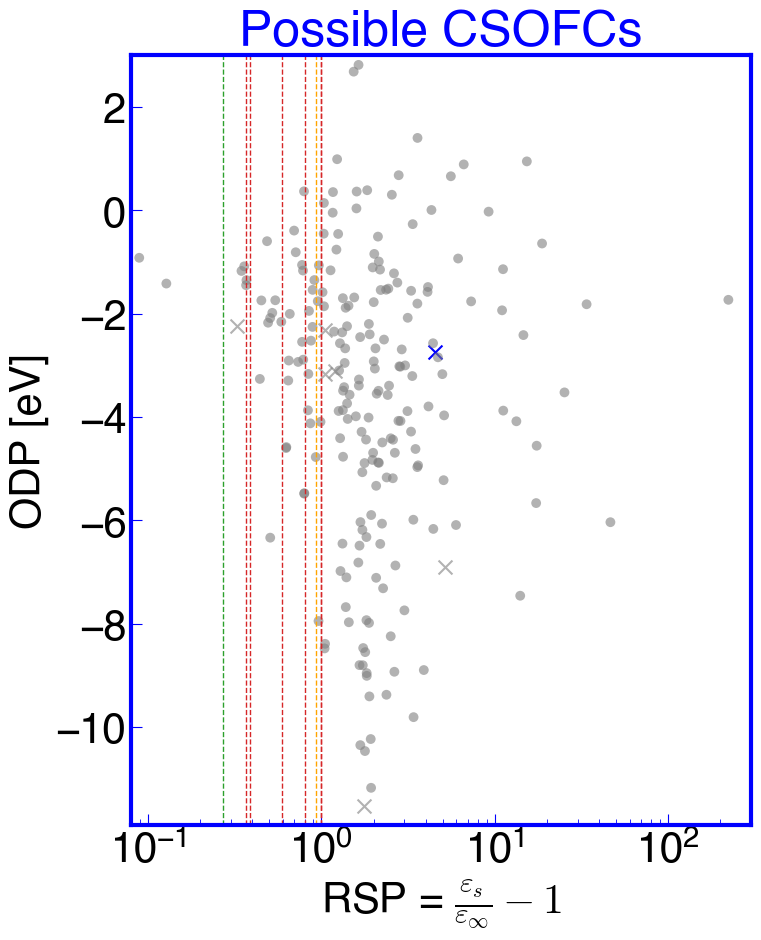

In [29]:
plt.figure(figsize=(8,10))

g = rsp_df.loc[CSOFCs]
g_exp = g.loc[g.RSP_theoretical == 0]
g_the = g.loc[g.RSP_theoretical == 1]

for tag, g in enumerate([g_exp, g_the]):
    ga = g.loc[g.chemical_formula!='CeO2']
    ceo = g.loc[g.chemical_formula=='CeO2'].loc[g.space_group==225]
    
    plt.scatter(ga.e_ionic/ga.e_electronic, ga.ODP, s=[100, 50][tag], alpha=0.6, marker=['x', 'o'][tag], c='gray', edgecolor='none')
    plt.scatter(ceo.e_ionic/ceo.e_electronic, ceo.ODP, s=[100, 50][tag], marker=['x', 'o'][tag], c='blue')
    
plt.axvline(29/22.8-1, linestyle='--', color='C2', linewidth=1) #YSZ

BYCO = rsp_df.loc[rsp_df.chemical_formula=='Ba2YCu3O7']
plt.axvline(list(BYCO.e_ionic/BYCO.e_electronic)[0], linestyle='--', color='orange', linewidth=1)

#Bi-doped La2Mo2O9
plt.axvline(37/37, linestyle='--', color='C3', linewidth=1)
plt.axvline(14/36, linestyle='--', color='C3', linewidth=1)
plt.axvline(15/41, linestyle='--', color='C3', linewidth=1)
plt.axvline(24/30, linestyle='--', color='C3', linewidth=1)
plt.axvline(34/34, linestyle='--', color='C3', linewidth=1)
plt.axvline(22/37, linestyle='--', color='C3', linewidth=1)

plt.xlim([8e-2, 3e2])
plt.ylim([-11.9, 3])
plt.tick_params(direction='in', which='both', length=4, color='blue')
plt.tick_params(direction='in', length=8, color='blue')
plt.xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
plt.ylabel('ODP [eV]')
plt.xscale('log')
plt.title('Possible CSOFCs', color='blue')
plt.setp(plt.gca().spines.values(), lw=3, color='blue')
plt.show()

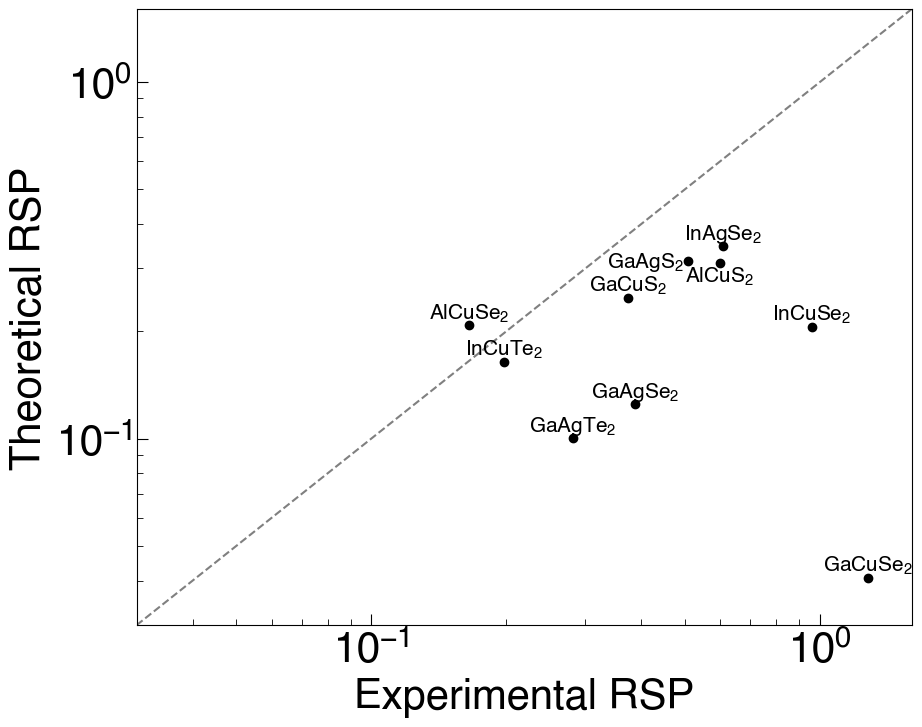

In [30]:
#for each materials it is given as (electronic, ionic)
#each constant is evaluated as (2*E(perpendicular)+E(parallel))/3
MP_chalcopyrites = {'AlCuS2':[(6.651*2+6.553)/3, (1.936*2+2.304)/3], 'AlCuSe2':[(8.36*2+8.416)/3, (1.597*2+2.033)/3],
                    'GaAgS2':[(7.783*2+7.702)/3, (2.267*2+2.777)/3], 'GaAgSe2':[(13.63*2+41.23)/3, (2.581*2+3.381)/3],
                    'GaAgTe2':[(16.51*2+25.8)/3, (1.798*2+2.296)/3], 'GaCuS2':[(8.752*2+8.823)/3, (1.94*2+2.656)/3],
                    'GaCuSe2':[(32.65*2+546.1)/3, (3.497*2+17.92)/3], 'InAgSe2':[(10.37*2+9.702)/3, (3.433*2+3.671)/3],
                    'InCuSe2':[(16.69*2+16.07)/3, (3.146*2+3.88)/3], 'InCuTe2':[(16.13*2+15.29)/3, (2.312*2+3.193)/3]}

for i, r in e_exp.iterrows():
    MP_electronic = MP_chalcopyrites[r.chemical_formula][0]
    MP_ionic = MP_chalcopyrites[r.chemical_formula][1]
    plt.scatter(r.e_ionic/r.e_electronic, MP_ionic/MP_electronic, c='k')
    if r.chemical_formula=='AlCuS2':
        plt.annotate(r.chemical_formula[:-1]+'$\\mathdefault{_{2}}$',
                     (r.e_ionic/r.e_electronic, MP_ionic/MP_electronic/1.01), fontsize=15, ha='center', va='top')
    elif r.chemical_formula=='GaAgS2':
        plt.annotate(r.chemical_formula[:-1]+'$\\mathdefault{_{2}}$',
                     (r.e_ionic/r.e_electronic/1.02, MP_ionic/MP_electronic), fontsize=15, ha='right', va='center')
    else:
        plt.annotate(r.chemical_formula[:-1]+'$\\mathdefault{_{2}}$', (r.e_ionic/r.e_electronic, MP_ionic/MP_electronic*1.01), fontsize=15, ha='center', va='bottom')

plt.plot(np.linspace(0.03, 1.6), np.linspace(0.03, 1.6), c='gray', linestyle='--')

plt.xlim([0.03, 1.6])
plt.ylim([0.03, 1.6])
plt.tick_params(direction='in', which='both', length=4)
plt.tick_params(direction='in', length=8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Experimental RSP')
plt.ylabel('Theoretical RSP')
plt.show()

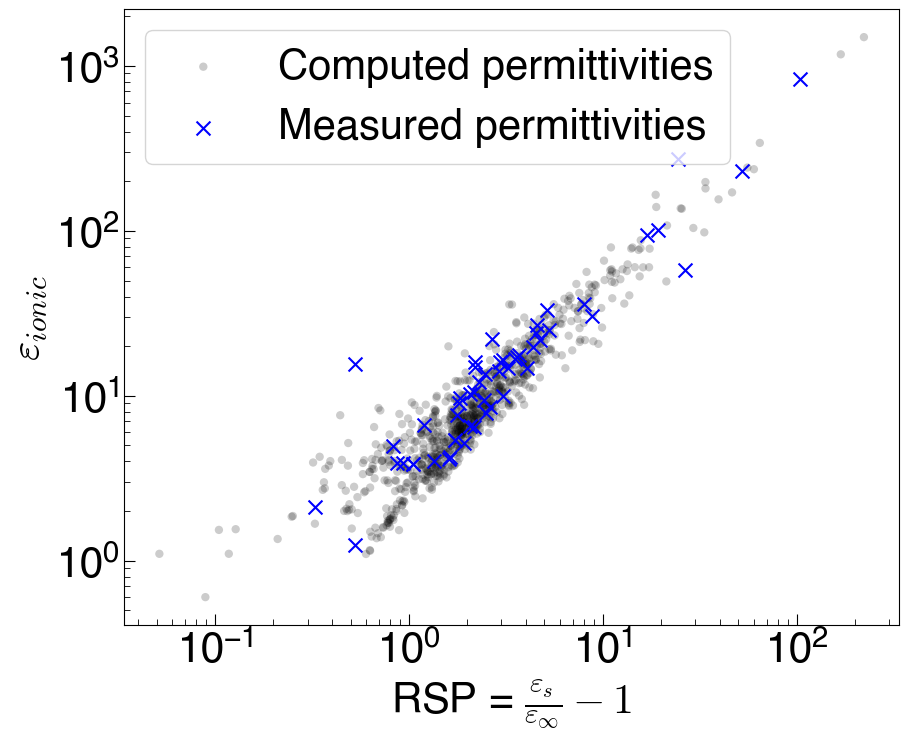

In [31]:
oxides = []
for index, row in rsp_df.iterrows():
    if 'YSZ' in row.chemical_formula or 'La1.' in row.chemical_formula:
        continue
        
    comp = Composition(row.chemical_formula)
    elements = list(comp.as_dict().keys())
    raw_cations = [a.split("', '")[0].replace("'", '').replace('(', '').replace('+', '')
                   for a in row.cation_coordination.split("), (")]
    cations = [''.join(c for c in cat if not c.isdigit()) for cat in raw_cations] #species
    cations = list(set(cations))
    ox_cations = []#species+state
    for cat in raw_cations: 
        if cat[-1].isdigit():
            ox_cations.append(cat)
        else:
            ox_cations.append(cat+'1')
    ox_cations = list(set(ox_cations))
    anions = [an for an in elements if an not in cations] #species

    if anions == ['O']:
        oxides.append(index)

oxides_df = rsp_df.loc[oxides]
exp_ox = oxides_df.loc[oxides_df.RSP_theoretical==0]
the_ox = oxides_df.loc[oxides_df.RSP_theoretical==1]
plt.scatter(the_ox.e_ionic/the_ox.e_electronic, the_ox.e_ionic,  alpha=.2, edgecolor='none', c='k', label='Computed permittivities')
plt.scatter(exp_ox.e_ionic/exp_ox.e_electronic, exp_ox.e_ionic, c='blue', alpha=1, label='Measured permittivities', s=100, marker='x')
plt.xscale('log')
plt.yscale('log')
plt.tick_params(direction='in', which='both', length=4)
plt.tick_params(direction='in', length=8)
plt.legend()
plt.xlabel('RSP = $\\frac{\\varepsilon_{s}}{\\varepsilon_{\infty}}-1$')
plt.ylabel('$\\varepsilon_{ionic}$')
plt.show()